# Riskfolio-Lib Tutorial: 
<br>__[Original paper](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2708678)__
<br>__[Riskfolio documentation](https://riskfolio-lib.readthedocs.io/en/latest/)__
<br>__[Brennan Bushee](https://www.linkedin.com/in/brennan-bushee-268273b8/)__
<br>
DISCLAIMER: The following is a demonstration only— it does not constitute financial advice. As a general rule, do not act on financial advice from strangers on the Internet.  The math is real, all opinions expressed are my own, and the financial data are outdated and possibly fake for all you know. For advice relevant to your particular situation, hire a (better) professional. 

## Performance Analysis of a Novel Clustering Method for Asset Allocation with a Real Portfolio
In Parts 1 and 2, we encountered some of the shortcomings of determining allocations the old-fashioned way, saw just a few of the myriad math problems involved in asset management, and saw (literally) what all this math bought us. This is still an area of active research (the original paper only came out in 2016), and I have not seen anything online that explained to my satisfaction how the portfolio is actually constructed without too many equations, too much finance bro jargon, or both. I'm a good explainer, or so I've been told, so I will set out to remedy that in this notebook. 


# 1. Downloading the data:

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import warnings
import pyfolio as pf
import pypfopt

warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:.4%}'.format

# Date range
start = '2016-01-01'
end = '2024-12-20'

# Tickers of assets
assets = ['APH', 'COST', 'FAST', 'GOOGL', 'LANC', 'LSTR', 'MIDD', 'MNST',
          'MU', 'ODFL', 'RACE', 'SSD', 'SPY', 'TXN', 'V', 'WAT', 'TTC'
         ]
assets.sort()

# Downloading data
data = yf.download(assets, start = start, end = end)
data = data.loc[:,('Adj Close', slice(None))]

data.columns = assets

/Users/brennan/opt/anaconda3/envs/pyquant/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/brennan/opt/anaconda3/envs/pyquant/lib/python3.8/site-packages/pyfolio/pos.py:25: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(
[*********************100%%**********************]  17 of 17 completed


In [2]:
# Calculating returns

Y = data.pct_change().dropna()

display(Y.head())

,APH,COST,FAST,GOOGL,LANC,LSTR,MIDD,MNST,MU,ODFL,RACE,SPY,SSD,TTC,TXN,V,WAT
Date,,,,,,,,,,,,,,,,,
2016-01-05,-1.1205%,0.2444%,-1.0948%,0.2752%,2.7908%,-0.4949%,1.4763%,1.1986%,3.4194%,0.8730%,2.3212%,0.1691%,1.4519%,0.5534%,-1.0489%,0.7529%,-0.4143%
2016-01-06,-2.3658%,-0.9254%,0.2767%,-0.2889%,-0.2585%,-1.1835%,-5.7172%,0.1575%,-4.0486%,-2.3927%,-2.9285%,-1.2614%,-0.7454%,-1.6923%,-0.6509%,-1.3111%,-0.0770%
2016-01-07,-3.6042%,-2.2910%,-2.0321%,-2.4140%,0.4061%,-1.5969%,-5.1302%,-0.7519%,-3.9381%,-3.8422%,-0.8923%,-2.3992%,-2.5233%,-2.3513%,-3.2198%,-1.9662%,-0.6861%
2016-01-08,-1.4998%,-1.7504%,-0.6402%,-1.3617%,-1.8934%,0.1764%,-2.2169%,-0.6543%,-2.4158%,-0.7413%,-7.5884%,-1.0976%,-0.9861%,-1.9206%,-2.5919%,-1.2332%,-1.6302%
2016-01-11,-0.7720%,1.7158%,0.2320%,0.2955%,0.0088%,0.1408%,-2.8393%,1.2409%,-6.0015%,-0.7286%,0.6263%,0.0990%,0.3112%,1.1691%,1.6879%,1.4270%,-0.5051%


In [3]:
## The problem, illustrated
split_date = '2022-01-04'
# Split the DataFrame

Y_before = Y.loc[:split_date]   # Includes rows up to the split date
Y_after = Y.loc[split_date:]   # Includes rows from the split date onward

# Optionally exclude the split_date in the second part
Y_after = Y.loc[split_date:]  # If you want to keep the split date in 'after'
#print("Before Split:")
#print(Y_before)

#print("\nAfter Split:")
#print(Y_after)
Y_before.pop("SPY")
benchmark_rets = Y_after.pop("SPY")
portfolio_returns = Y_after.sum(axis=1)

benchmark_rets, portfolio_returns

(Date
 2022-01-04   -0.0335%
 2022-01-05   -1.9202%
 2022-01-06   -0.0940%
 2022-01-07   -0.3954%
 2022-01-10   -0.1244%
                ...   
 2024-12-13   -0.0199%
 2024-12-16    0.4270%
 2024-12-17   -0.4120%
 2024-12-18   -2.9803%
 2024-12-19   -0.0307%
 Name: SPY, Length: 745, dtype: float64,
 Date
 2022-01-04    12.5278%
 2022-01-05   -30.3716%
 2022-01-06    -1.0464%
 2022-01-07   -26.7494%
 2022-01-10   -12.7600%
                 ...   
 2024-12-13    -1.3704%
 2024-12-16    -2.9325%
 2024-12-17   -14.7853%
 2024-12-18   -49.4783%
 2024-12-19   -22.6507%
 Length: 745, dtype: float64)

# In Case You Missed It: Review of Parts 1 and 2
## My wish list for an allocation strategy
- 3-5 year time horizon
- Don't lose more than ~50% in the worst case scenario
- The strategy should want to give some weight to each stock I have screened for, or I should be able to make that a constraint: I believe each of these stocks could make market-beating returns.
- It would ideally not require me to pass in expected future returns for each asset: if I had a reliable way to predict those, I wouldn't give it away for free in here.
- I am not willing to entrust my life savings to a "black box" algorithm. I want to be able to see its inner workings and see if they make sense qualitatively. I would especially not give free rein to a trading bot. 


## My risk metric: Conditional Drawdown at Risk (CDaR)
As we discussed previously, "drawdown" is the largest distance to a "valley" on the stock's price chart from the previous "peak", which is one way of measuring the most you could conceivably lose over a given time horizon. Conditional drawdown at risk is the weighted average of the worst 5% (typically) of scenarios. The risk contribution of each individual stock in this case is the weighted average of how much that particular stock goes down across that same set of scenarios.

# How the Hierarchial Risk Parity (HRP) algorithm creates clusters
Finding a minimum-variance portfolio the old-fashioned way is formulated as  this constrained optimization problem:
\begin{aligned} 
min \frac{1}{2}w^{T}\sigma w - \gamma \mu^{T} w
\end{aligned}
\begin{aligned} 
s.t. e^{T}w = 1; e = 1^{T} 
\end{aligned}
If w is the weight allocated to each asset. (or percent of our capital allocated in our case). The \gamma is a factor we get to choose to determine how much importance we place our mean expected return \mu w. I picked each of these stocks because I'm fairly sure they have a good chance of beating the market, but I have no idea by how much. Therefore, I will keep my \gamma relatively low, not because I couldn't use more gains, but because I didn't want to rely too much on future price predictions.

For our situation, the problem setup and solution are shown here.


In [5]:
# Building the portfolio object
import riskfolio as rp
port = rp.HCPortfolio(returns=Y_before)
port.codep
# Estimate optimal portfolio:

model='HRP' # Could be HRP or HERC
codependence = 'abs_pearson' # Correlation matrix used to group assets in clusters
rm = 'CDaR' # Risk measure used, this time it will be CDaR
rf = 0 # Risk free rate
linkage = 'DBHT' # Linkage method used to build clusters
max_k = 10 # Max number of clusters used in two difference gap statistic, only for HERC model
leaf_order = True # Consider optimal order of leafs in dendrogram

w = port.optimization(model=model,
                      codependence=codependence,
                      obj="Sharpe",
                      rm=rm,
                      rf=rf,
                      linkage=linkage,
                      max_k=max_k,
                      leaf_order=leaf_order)

display(w.T)



,APH,COST,FAST,GOOGL,LANC,LSTR,MIDD,MNST,MU,ODFL,RACE,SSD,TTC,TXN,V,WAT
weights,5.1061%,10.4567%,7.7494%,8.0719%,8.0449%,6.6381%,2.4907%,6.4265%,2.5869%,5.3873%,5.4217%,6.4100%,6.5903%,6.7467%,6.8178%,5.0549%


UnboundLocalError: local variable 'b' referenced before assignment

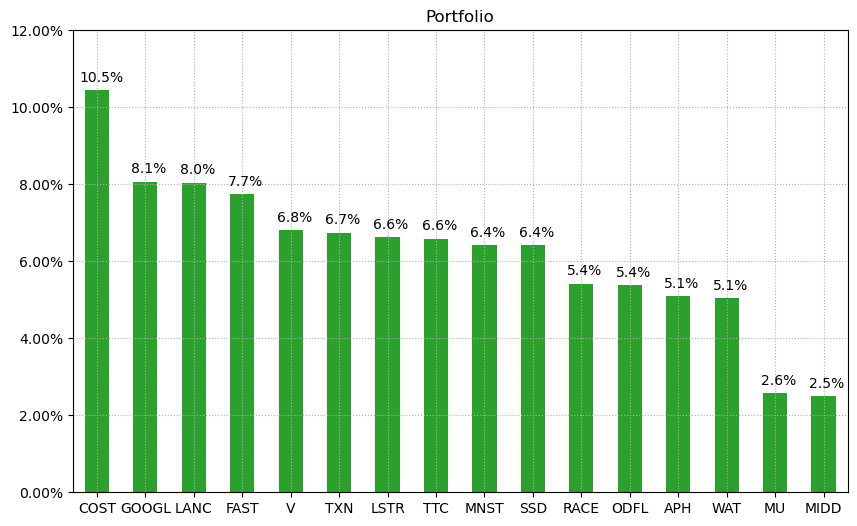

In [6]:
ax = rp.plot_bar(w,
                 title='Portfolio',
                 kind="v",
                 # others=0.05,
                 nrow=25,
                 height=6,
                 width=10,
                 ax=None)

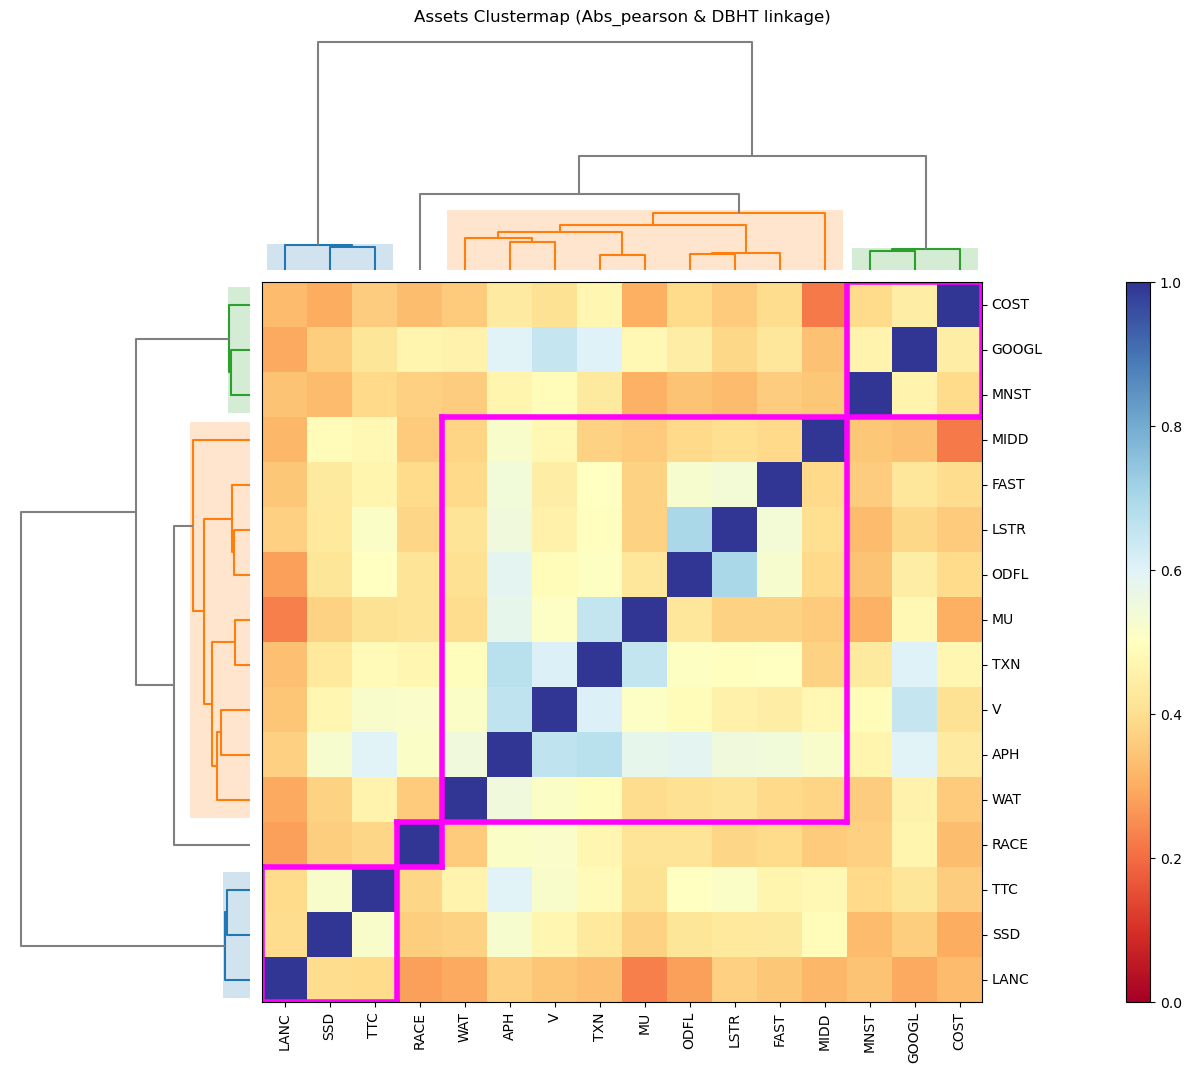

In [7]:
import riskfolio as rp

# Plotting Assets Clusters

ax = rp.plot_clusters(returns=Y_before,
                        codependence='abs_pearson',
                        linkage='DBHT',
                        k=None,
                        max_k=10,
                        cmap='RdYlBu',
                        leaf_order=True,
                        ax=None)

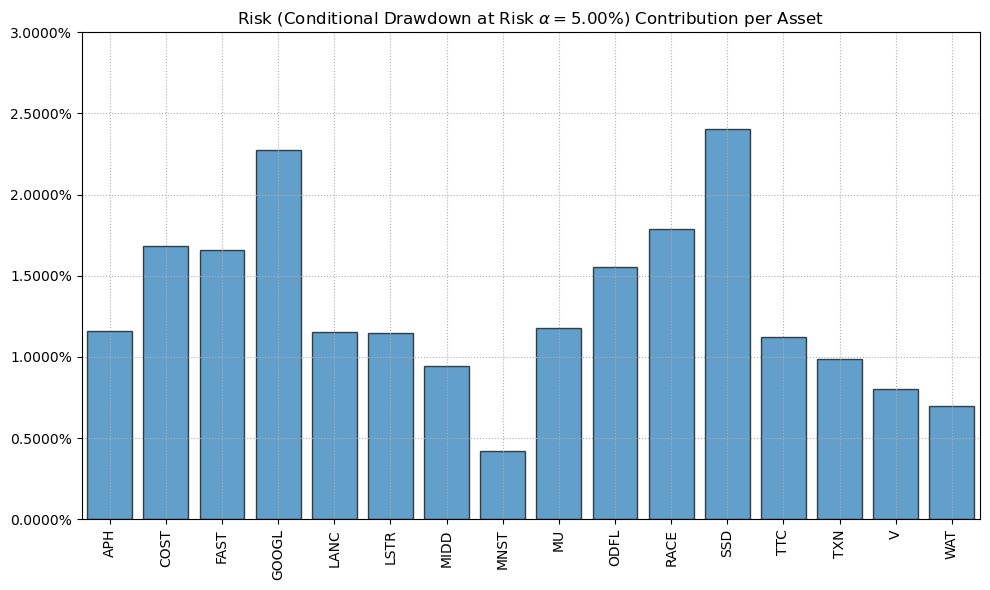

In [8]:
# Plotting the composition of the portfolio

# Plotting the risk contribution per asset

mu = Y_before.mean()
cov = Y_before.cov() # Covariance matrix
returns = Y_after # Returns of the assets

ax = rp.plot_risk_con(w=w,
                      cov=cov,
                      returns=returns,
                      rm=rm,
                      rf=0,
                      alpha=0.05,
                      color="tab:blue",
                      height=6,
                      width=10,
                      t_factor=252,
                      ax=None)

## Portfolio construction step by step

These clusters make an extraordinary amount of qualitative sense when you walk through the process:
<br> 1.) Combine Old Dominion Freight Lines (ODFL) and Landstar(LSTR), both trucking companies.
<br> 2.) Combine Texas Instruments (TXN) and Micron (MU), both in the semiconductor business, which has seen its ups and downs these past few years.
<br> 3.) Combine Amphenol (APH) with TXN-MU.
<br> 4.) Combine Fastenal (FAST) with ODFL-LSTR.
<b4> 5.) Combine Combine Waters (WAT) with WAT-APH-TXN-MU. The addition of Amphenol made this cluster more industrial, thus moving it closer to Waters.
<br>6.) Combine WAT-APH-TXN-MU with FAST-ODFL-LSTR to make a manufacturing and transport supercluster.
<br>7.) Combine Costco (COST) , Google (GOOGL), and Monster Energy (MNST) in no particular order. 
<br>8.) Combine Lancaster Colony (LANC), Simpson Manufacturing (SSD), and The Toro Company (the lawnmower people). As the distances get greater, these clusters seem to make less and less sense qualitatively, which could be seen as good news or bad news.
<br> 9.) Combine Middleby (MIDD), another manufacturer (of kitchen appliances, mostly for industrial settings), to the supercluster from (6). 
<br> 10.) Ferrari (RACE) doesn't correlate well with anything really, but add that to the supercluster above. 
<br> 11.) Combine COST-GOOGL-MNST to the supercluster, leaving and then link LANC-SSD-TTC to it to finally form one big cluster.

Even though the construction of the clusters is a bottom-up process, the allocation of weights is a top-down process. We start with the one big cluster we created above, and then recursively bisect it, allocating the risk equally among the subclusters inside of it. We then take the weight allocated to each subcluster and then allocate risk within each of them, following that approach all the way down until each individual asset is allocated a weight w. This is the inverse-volatility strategy, which is hardly a new idea, adapted to clusters instead of individual stocks. For illustrative purposes, here is a fictitious example with three stocks (instead of three subclusters).

##
### **Step-by-Step Math Behind the Strategy:**

Let’s assume you have *n* different assets to invest in. We’ll assign weights w to each asset, which represent the percentage of your total money that goes into each investment.

1. **Calculate Volatility for Each Asset:**
   - For each asset *i*, calculate its volatility \begin{aligned} \sigma_i\end{aligned}.

2. **Compute Inverse Volatility:**
   - Find the **inverse** of each volatility to give low-volatility assets bigger numbers and high-volatility assets smaller numbers.

3. **Normalize the Weights:**
   - To make sure all the weights add up to 100% of your money (no more, no less), normalize them:
     \begin{aligned}
     w_i = \frac{\frac{1}{\sigma_i}}{\sum_{j=1}^{n} \frac{1}{\sigma_j}}
     \end{aligned}
   - Where each of the w's is the  weight (percentage of money) invested in asset *i*.

---

### **Example:**

Suppose you have 3 assets with the following volatilities:

| **Asset** | **Volatility** | **Inverse Volatility** |
|-----------|----------------------------|--------------------------------------|
| Asset A   | 10%                        | 1/0.10 = 10                          |
| Asset B   | 20%                        | 1/0.20 = 5                           |
| Asset C   | 40%                        | 1/0.40 = 2.5                         |

**Step 1: Sum the Inverse Volatilities:**  
10 + 5 + 2.5 = 17.5


**Step 2: Calculate Weights:**  
\begin{aligned}
w_A = \frac{10}{17.5} = 57.14\%  
\end{aligned}
\begin{aligned}
w_B = \frac{5}{17.5} = 28.57\%  
\end{aligned}
\begin{aligned}
w_C = \frac{2.5}{17.5} = 14.29\% 
\end{aligned}
 


**Result:**
- You invest *57%* in Asset A (the least volatile).
- You invest *29%* in Asset B (moderate volatility).
- You invest *14%* in Asset C (the most volatile).


The above example, of course, doesn't take into account covariances between any two of these assets, but a clustering approach does.

# Conclusion
I was a math major, but I tell people I don't like "pi in the sky" math-- I like solving practical problems. This is an example of when equations align surprisingly well with common sense and when short-term goals (finishing grad school) align with long-term goals (making back the money I spent on grad school, eventually having lots of money while not losing too much sleep over market movements in the meantime).
I hope also that this can also serve as an example of when math is useful for the general reader. It's surprising how many "general readers" think that math is hard, but for some reason think investment management is easy. Or how many think that math is useless, but then are appalled at how much portfolio managers make. They'll say, "I could do that if I tried", but the thing is that you have to try for 20-30 years, acquire the mathematical toolkit, learn where you stand within the financial landscape, and  be right more often than not about the financial markets, which are the reason I know the word "volatile". There are plenty of things I've glossed over, but as the saying goes, there are two keys to success. Key #1 is to never tell everything you know...